# Meep FDTD

[Meep](https://meep.readthedocs.io/en/latest/) is a free and open source finite-difference time-domain (FDTD) software package for electromagnetic simulations spanning a broad range of applications.

You can install Meep and the mode solver MPB (which Meep uses to compute S-parameters and launch mode sources) using one of two methods:

1. Mamba (faster)

```
mamba install pymeep=*=mpi_mpich_* -y
```

2. Conda

```
conda install -c conda-forge pymeep=*=mpi_mpich_* -y
```

To update the installed package, you would do:

```
mamba update pymeep=*=mpi_mpich_* -y
```

The Mamba/Conda packages are available for Linux, macOS, or Windows [WSL](https://docs.microsoft.com/en-us/windows/wsl/). For more details on installing Meep, see the [user manual](https://meep.readthedocs.io/en/latest/Installation/#conda-packages).


The gdsfactory `gmeep` plugin computes the transmission spectrum for planar photonic components.

One advantage of using the `gmeep` plugin is that you only need to define your component geometry *once* using gdsfactory. The geometry is automatically imported into Meep. There is no need to define the geometry separately for Meep.

For extracting S-parameters, `gmeep` automatically swaps the source between ports to compute the full S-matrix. This process involves:

- adding monitors to each port of the device
- extending the ports into the PML absorbing boundary layers
- running the simulation and computing elements of the S-matrix in post-processing using the correct ratio of S-parameters. The port monitors are used to compute the discrete-time Fourier-transformed (DTFT) fields which are then decomposed into complex mode coefficients known as S-parameters. The S-parameters can be computed over a range of frequencies.

The resolution is in units of pixels/μm. As a general rule, you should run with at least `resolution=30` for 1/30 μm/pixel (33 nm/pixel)

Note that most of the examples use `resolution=20` in order to run fast.

Here are some examples of how to extract S-parameters in Meep in planar devices.

For Sparameters we follow the syntax `o1@0,o2@0` where `o1` is the input port `@0` mode 0 (usually fundamental TE mode) and `o2@0` refers to output port `o2` mode 0.


```bash

         top view
              ________________________________
             |                               |
             | xmargin_left                  | port_extension
             |<--------->       port_margin ||<-->
          o2_|___________          _________||_o3
             |           \        /          |
             |            \      /           |
             |             ======            |
             |            /      \           |
          o1_|___________/        \__________|_o4
             |   |                 <-------->|
             |   |ymargin_bot   xmargin_right|
             |   |                           |
             |___|___________________________|

        side view
              ________________________________
             |                     |         |
             |                     |         |
             |                   zmargin_top |
             |xmargin_left         |         |
             |<---> _____         _|___      |
             |     |     |       |     |     |
             |     |     |       |     |     |
             |     |_____|       |_____|     |
             |       |                       |
             |       |                       |
             |       |zmargin_bot            |
             |       |                       |
             |_______|_______________________|



```

## Serial Simulation (single core)

Running Meep using a single CPU core can be slow as the single core needs to update all the simulation grid points sequentially at each time step.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import gdsfactory as gf
import gdsfactory.simulation.gmeep as gm
import gdsfactory.simulation as sim

gf.config.set_plot_options(show_subports=False, show_ports=False)

2023-01-03 02:13:16.542 | INFO     | gdsfactory.config:<module>:48 - Load '/home/runner/work/gdsfactory/gdsfactory/gdsfactory' 6.17.0


Using MPI version 4.0, 1 processes


2023-01-03 02:13:17.905 | INFO     | gdsfactory.simulation.gmeep:<module>:34 - Meep '1.25.0-beta' installed at ['/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/meep']


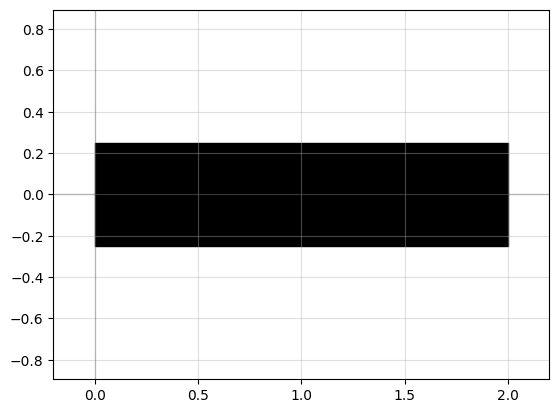

straight_length2: uid effc4e92, ports ['o1', 'o2'], references [], 1 polygons

In [2]:
c = gf.components.straight(length=2)
c

`run=False` only plots the simulations for you to review that is set up **correctly**

[02:13:18] INFO     Using client version: 1.8.1                                                     ]8;id=907528;file:///usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/tidy3d/__init__.py\__init__.py]8;;\:]8;id=338981;file:///usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/tidy3d/__init__.py#112\112]8;;\

2023-01-03 02:13:18.821 | INFO     | gdsfactory.simulation.gtidy3d:<module>:54 - Tidy3d '1.8.1' installed at ['/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/tidy3d']


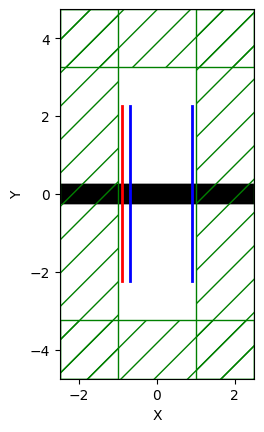

In [3]:
sp = gm.write_sparameters_meep(c, run=False, ymargin_top=3, ymargin_bot=3, is_3d=False)

In [4]:
help(gm.write_sparameters_meep)

Help on cython_function_or_method in module gdsfactory.simulation.gmeep.write_sparameters_meep:

write_sparameters_meep(component: 'ComponentSpec', port_source_names: 'Optional[List[str]]' = None, port_symmetries: 'Optional[PortSymmetries]' = None, resolution: 'int' = 30, wavelength_start: 'float' = 1.5, wavelength_stop: 'float' = 1.6, wavelength_points: 'int' = 50, dirpath: 'Optional[PathType]' = None, layer_stack: 'Optional[LayerStack]' = None, port_margin: 'float' = 2, port_monitor_offset: 'float' = -0.1, port_source_offset: 'float' = -0.1, filepath: 'Optional[Path]' = None, overwrite: 'bool' = False, animate: 'bool' = False, lazy_parallelism: 'bool' = False, run: 'bool' = True, dispersive: 'bool' = False, xmargin: 'float' = 0, ymargin: 'float' = 3, xmargin_left: 'float' = 0, xmargin_right: 'float' = 0, ymargin_top: 'float' = 0, ymargin_bot: 'float' = 0, decay_by: 'float' = 0.001, is_3d: 'bool' = False, z: 'float' = 0, **settings) -> 'Dict'
    Returns Sparameters and writes them to

As you've noticed we added `ymargin_top` and `ymargin_bot` to ensure we have enough distance to the PML

You can also do this directly with another version of the function that adds `ymargin_top` and `ymargin_bot`

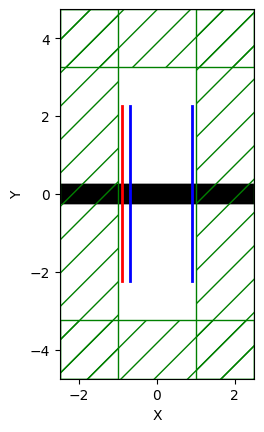

In [5]:
c = gf.components.straight(length=2)
sp = gm.write_sparameters_meep(c, run=False, is_3d=False)

Because components with `left-right` ports are very common `write_sparameters_meep` `y_margin = 3um `

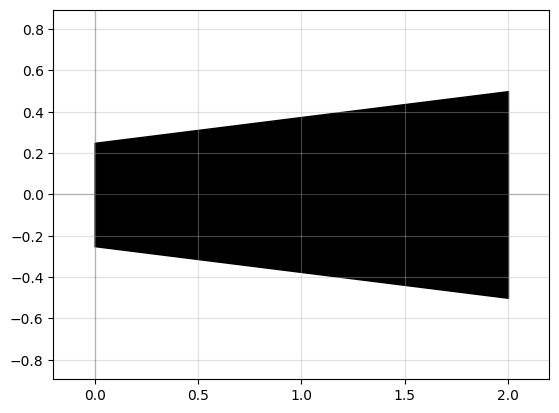

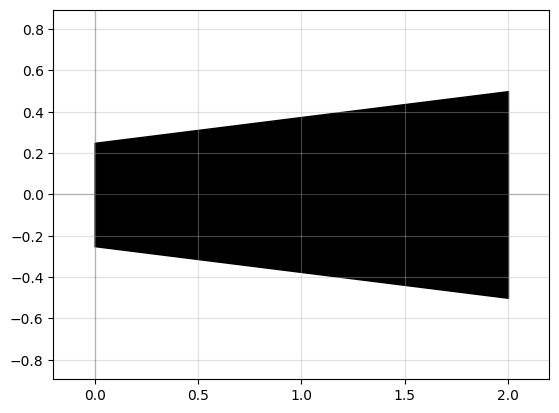

taper_length2p0_width21: uid 0530c6e0, ports ['o1', 'o2'], references [], 1 polygons

In [6]:
c = gf.components.taper(length=2.0, width1=0.5, width2=1)
c

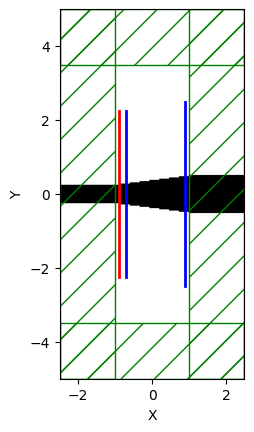

In [7]:
sp = gm.write_sparameters_meep(c, run=False)

## 2.5D Simulation

For faster simulations you can do an effective mode approximation, to compute the mode of the slab and run a 2D simulation to speed your [simulations](https://www.lumerical.com/learn/whitepapers/lumericals-2-5d-fdtd-propagation-method/)

In [8]:
ncore = sim.get_effective_indices(
    ncore=3.4777,
    ncladding=1.444,
    nsubstrate=1.444,
    thickness=0.22,
    wavelength=1.55,
    polarization="te",
)[0]

ncore

2.8494636999424405

In [9]:
sp = gm.write_sparameters_meep(
    c, resolution=20, is_3d=False, material_name_to_meep=dict(si=ncore)
)

2023-01-03 02:13:19.612 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep:write_sparameters_meep:343 - Simulation loaded from PosixPath('/home/runner/work/gdsfactory/gdsfactory/gdslib/sp/taper_length2p0_width21_9b4a7ae1.npz')


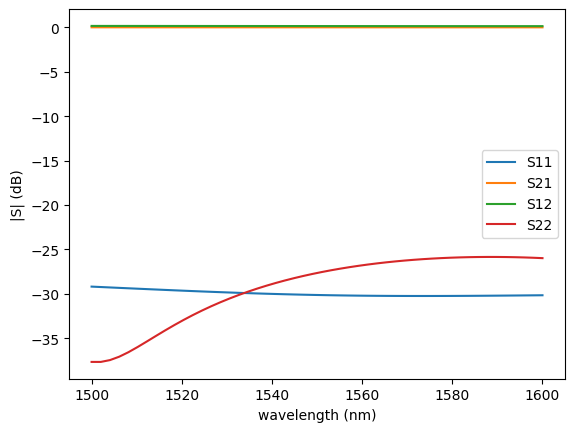

In [10]:
gf.simulation.plot.plot_sparameters(sp)

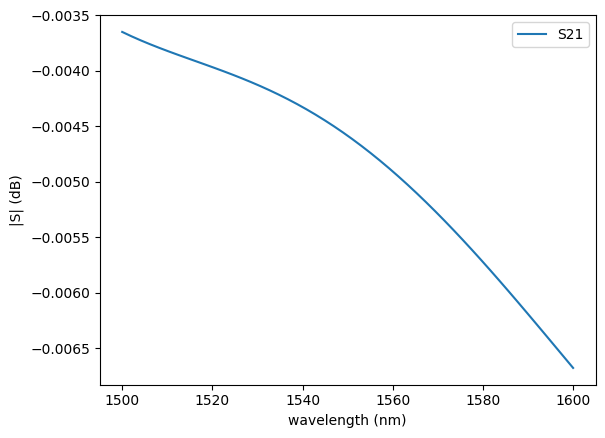

In [11]:
gf.simulation.plot.plot_sparameters(sp, keys=("o2@0,o1@0",))

For a small taper length, the matrix element S$_{21}$ (transmission in Port 2 given a source in Port 1) is around 0 dB which is equivalent to ~100% transmission.

## Port Symmetries

You can skip redundant simulations in reciprocal devices.
If the device looks the same going from in -> out as out -> in, we just need to run one simulation.

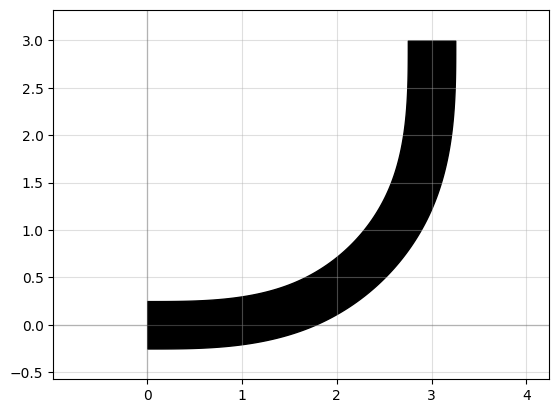

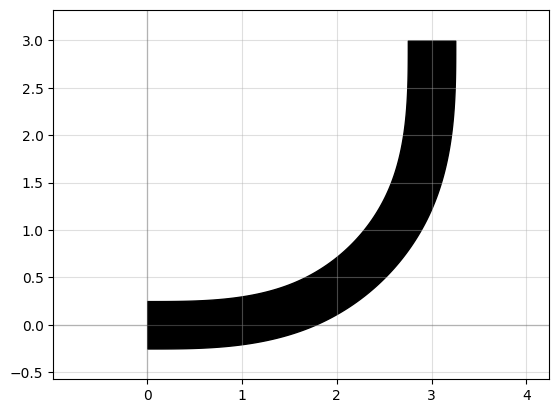

bend_euler_radius3: uid 583e27bd, ports ['o1', 'o2'], references [], 1 polygons

In [12]:
c = gf.components.bend_euler(radius=3)
c

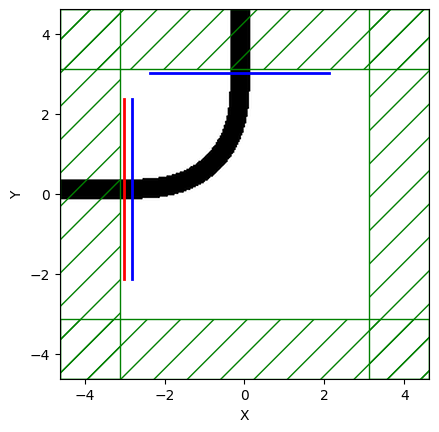

In [13]:
sp = gm.write_sparameters_meep_1x1_bend90(c, run=False)

In [14]:
sp = gm.write_sparameters_meep_1x1_bend90(c, run=True)

2023-01-03 02:13:21.683 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep:write_sparameters_meep:343 - Simulation loaded from PosixPath('/home/runner/work/gdsfactory/gdsfactory/gdslib/sp/bend_euler_radius3_ac679e22.npz')


In [15]:
list(sp.keys())

['o1@0,o1@0', 'o2@0,o1@0', 'o2@0,o2@0', 'o1@0,o2@0', 'wavelengths']

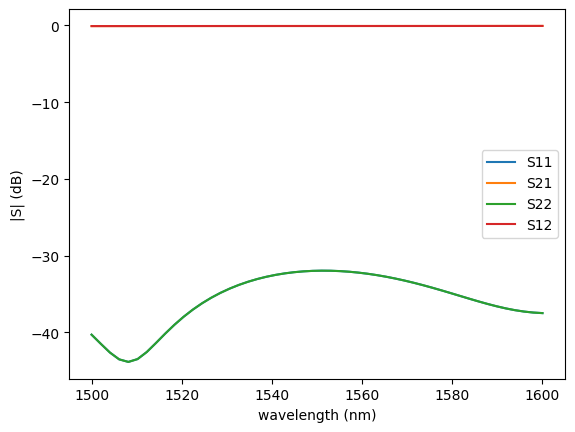

In [16]:
gf.simulation.plot.plot_sparameters(sp)

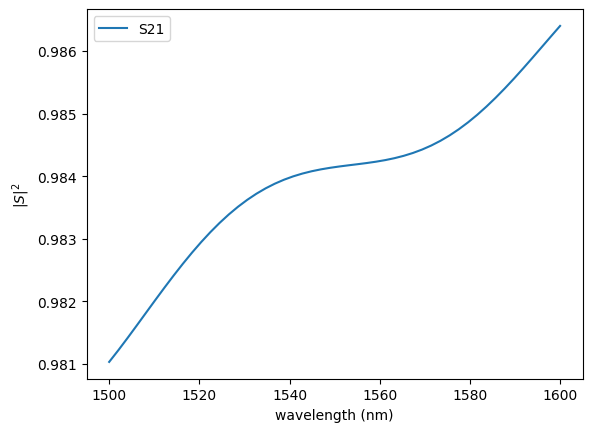

In [17]:
gf.simulation.plot.plot_sparameters(sp, keys=("o2@0,o1@0",), logscale=False)

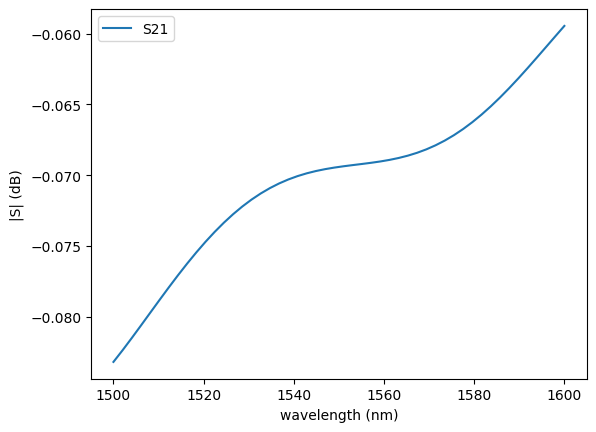

In [18]:
gf.simulation.plot.plot_sparameters(sp, keys=("o2@0,o1@0",))

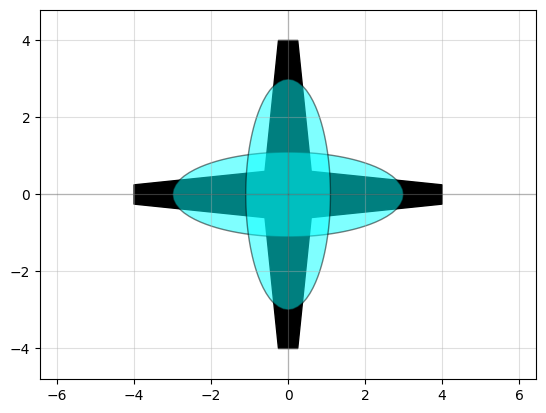

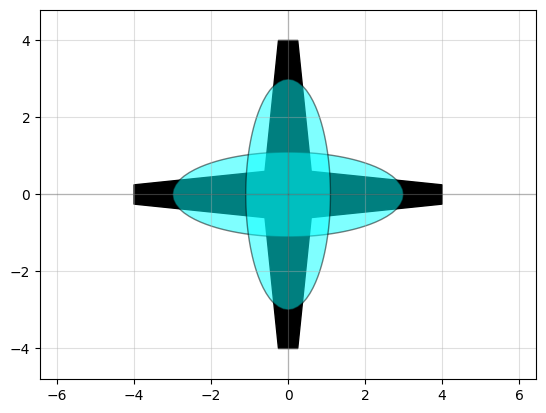

crossing: uid 92492e1c, ports ['o1', 'o3', 'o4', 'o2'], references [], 4 polygons

In [19]:
c = gf.components.crossing()
c

Here are the port symmetries for a crossing

```python
port_symmetries_crossing = {
    "o1": {
        "o1@0,o1@0": ["o2@0,o2@0", "o3@0,o3@0", "o4@0,o4@0"],
        "o2@0,o1@0": ["o1@0,o2@0", "o3@0,o4@0", "o4@0,o3@0"],
        "o3@0,o1@0": ["o1@0,o3@0", "o2@0,o4@0", "o4@0,o2@0"],
        "o4@0,o1@0": ["o1@0,o4@0", "o2@0,o3@0", "o3@0,o2@0"],
    }
}
```

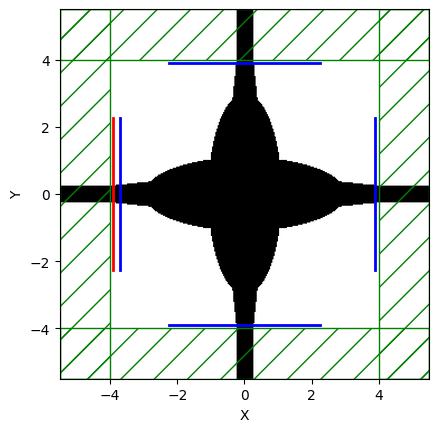

In [20]:
sp = gm.write_sparameters_meep(
    c,
    resolution=20,
    ymargin=0,
    port_symmetries=gm.port_symmetries.port_symmetries_crossing,
    run=False,
)

In [21]:
sp = gm.write_sparameters_meep(
    c,
    resolution=20,
    ymargin=0,
    port_symmetries=gm.port_symmetries.port_symmetries_crossing,
    run=True,
)

2023-01-03 02:13:23.091 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep:write_sparameters_meep:343 - Simulation loaded from PosixPath('/home/runner/work/gdsfactory/gdsfactory/gdslib/sp/crossing_af6d7b1b.npz')


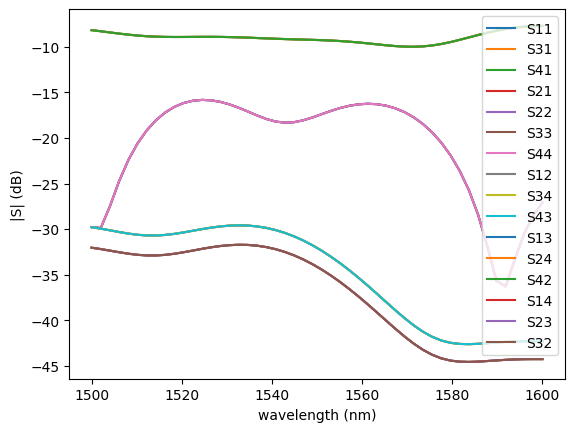

In [22]:
gm.plot.plot_sparameters(sp)

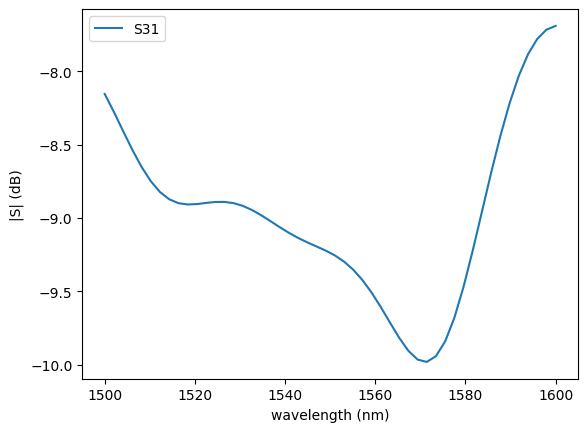

In [23]:
gm.plot.plot_sparameters(sp, keys=("o3@0,o1@0",))

As you can see this crossing looks beautiful but is quite **lossy** (9 dB @ 1550 nm)

## Parallel Simulation (multicore/MPI)

Meep supports [distributed-memory parallelization via MPI](https://meep.readthedocs.io/en/latest/Parallel_Meep/) which can be used to provide a significant speedup compared to serial calculations.

By default MPI just runs the same copy of the Python script everywhere, with the C++ under MEEP actually being parallelized.

`divide_parallel_processes` allows us to logically split this one calculation into (in this case "cores") subdivisions.
The only difference in the scripts is that a different integer n is returned depending on the subdivision it is running in.

So we use that n to select different sources, and each subdivision calculates its own Sparams independently.
Afterwards, we collect all the results in one of the subdivisions (if rank == 0)

As a demonstration, lets try to reproduce the results of the directional coupler results from the [Meep manual](https://meep.readthedocs.io/en/latest/Python_Tutorials/GDSII_Import/) which indicates that to obtain a 3 dB (50%/50%) splitter you need a separation distance of 130 nm over a coupler length of 8 μm.

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

import gdsfactory as gf
import gdsfactory.simulation as sim
import gdsfactory.simulation.gmeep as gm

In [25]:
help(gf.components.coupler)

Help on function coupler in module gdsfactory.components.coupler:

coupler(gap: 'float' = 0.236, length: 'float' = 20.0, coupler_symmetric: 'ComponentSpec' = <function coupler_symmetric at 0x7f36a33db310>, coupler_straight: 'ComponentSpec' = <function coupler_straight at 0x7f36a33db160>, dy: 'float' = 5.0, dx: 'float' = 10.0, cross_section: 'CrossSectionSpec' = 'strip', **kwargs) -> 'Component'
    Symmetric coupler.
    
    Args:
        gap: between straights in um.
        length: of coupling region in um.
        coupler_symmetric: spec for bend coupler.
        coupler_straight: spec for straight coupler.
        dy: port to port vertical spacing in um.
        dx: length of bend in x direction in um.
        cross_section: spec (CrossSection, string or dict).
        kwargs: cross_section settings.
    
    .. code::
    
               dx                                 dx
            |------|                           |------|
         o2 ________                           ___

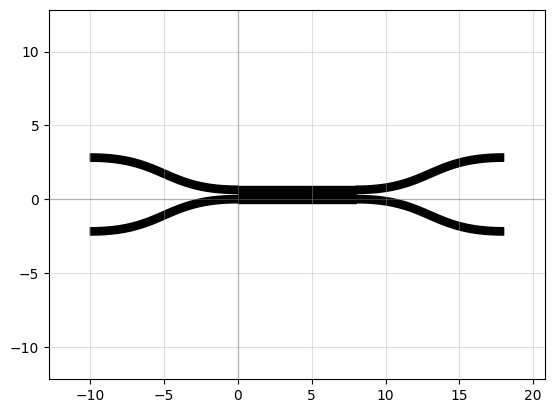

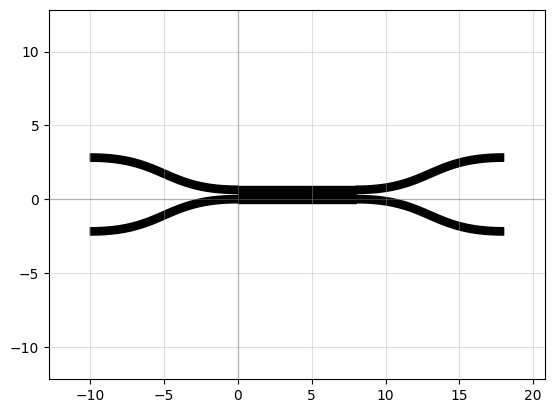

coupler_gap0p13_length8: uid 3de41bab, ports ['o1', 'o2', 'o3', 'o4'], references [], 6 polygons

In [26]:
c = gf.components.coupler(length=8, gap=0.13)
c

<meep.simulation.Simulation object at 0x7f367e72ba30>

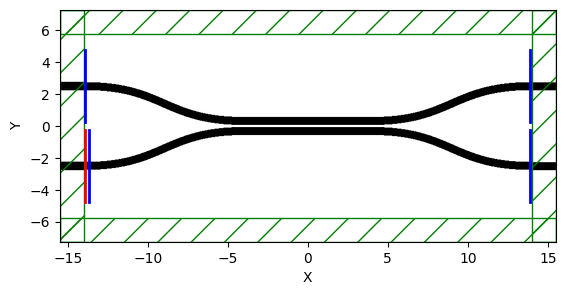

In [27]:
gm.write_sparameters_meep(component=c, run=False)

In [28]:
filepath = gm.write_sparameters_meep_mpi(
    component=c,
    cores=4,
    resolution=30,
)

2023-01-03 02:13:27.501 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:149 - Simulation PosixPath('/home/runner/work/gdsfactory/gdsfactory/gdslib/sp/coupler_gap0p13_length8_fccf022d.npz') already exists


In [29]:
sp = np.load(filepath)

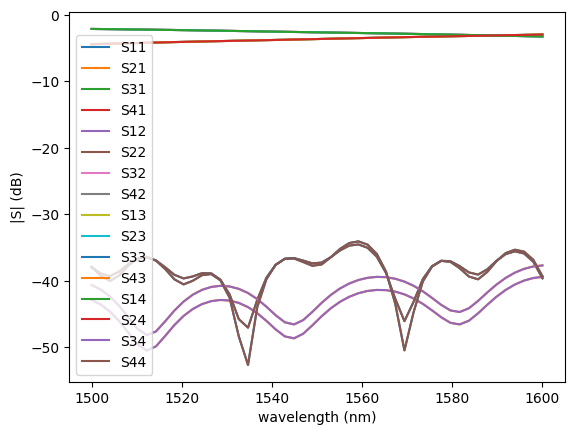

In [30]:
gf.simulation.plot.plot_sparameters(sp)

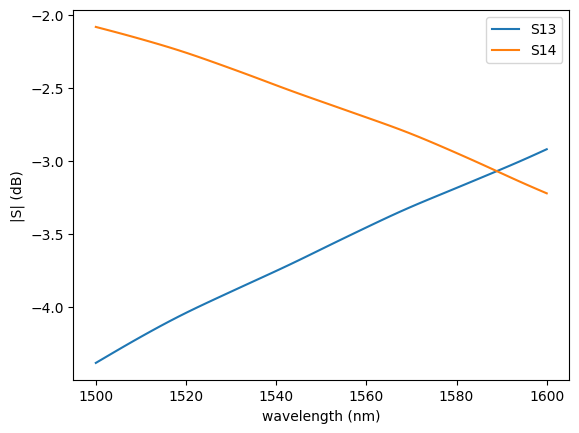

In [31]:
gf.simulation.plot.plot_sparameters(sp, keys=["o1@0,o3@0", "o1@0,o4@0"])

## Batch Simulations

You can also run a batch of multicore simulations.

Given a list of write_sparameters_meep keyword arguments `jobs` launches them in different cores using MPI where each simulation runs with "cores_per_run" cores.

If there are more simulations than cores each batch runs sequentially.

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gdsfactory as gf

import gdsfactory.simulation as sim
import gdsfactory.simulation.gmeep as gm

In [33]:
help(gm.write_sparameters_meep_batch)

Help on cython_function_or_method in module gdsfactory.simulation.gmeep.write_sparameters_meep_batch:

write_sparameters_meep_batch(jobs: 'List[Dict]', cores_per_run: 'int' = 2, total_cores: 'int' = 4, temp_dir: 'Path' = PosixPath('/home/runner/work/gdsfactory/gdsfactory/gdslib/sp/temp'), delete_temp_files: 'bool' = True, dirpath: 'Optional[Path]' = None, layer_stack: 'Optional[LayerStack]' = None, **kwargs) -> 'List[Path]'
    Write Sparameters for a batch of jobs using MPI and returns results filepaths.
    
    Given a list of write_sparameters_meep keyword arguments `jobs` launches them in
    different cores using MPI where each simulation runs with `cores_per_run` cores.
    If there are more simulations than cores each batch runs sequentially.
    
    
    Args
        jobs: list of Dicts containing the simulation settings for each job.
            for write_sparameters_meep.
        cores_per_run: number of processors to assign to each component simulation.
        total_cores

In [34]:
c = gf.components.straight(length=3.1)

<meep.simulation.Simulation object at 0x7f367c58ac70>

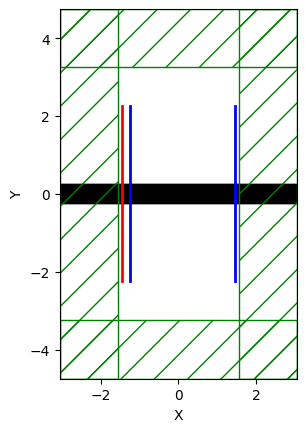

In [35]:
gm.write_sparameters_meep(c, ymargin=3, run=False)

In [36]:
c1_dict = {"component": c, "ymargin": 3}
jobs = [
    c1_dict,
]

filepaths = gm.write_sparameters_meep_batch_1x1(
    jobs=jobs,
    cores_per_run=4,
    total_cores=8,
    lazy_parallelism=True,
)

2023-01-03 02:13:28.053 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_batch:write_sparameters_meep_batch:138 - Simulation PosixPath('/home/runner/work/gdsfactory/gdsfactory/gdslib/sp/straight_length3p1_f9e9c23c.npz') not found. Adding it to the queue


2023-01-03 02:13:28.054 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_batch:write_sparameters_meep_batch:146 - Running 1 simulations


2023-01-03 02:13:28.054 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_batch:write_sparameters_meep_batch:147 - total_cores = 8 with cores_per_run = 4


2023-01-03 02:13:28.055 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_batch:write_sparameters_meep_batch:148 - Running 1 batches with up to 2 jobs each.


  0%|          | 0/1 [00:00<?, ?it/s]

2023-01-03 02:13:28.067 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_batch:write_sparameters_meep_batch:159 - Task 0 of batch 0 is job 0


2023-01-03 02:13:28.069 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:149 - Simulation PosixPath('/home/runner/work/gdsfactory/gdsfactory/gdslib/sp/straight_length3p1_d7285687.npz') already exists


{'component': straight_length3p1: uid e86745e2, ports ['o1', 'o2'], references [], 1 polygons,
 'ymargin': 3}


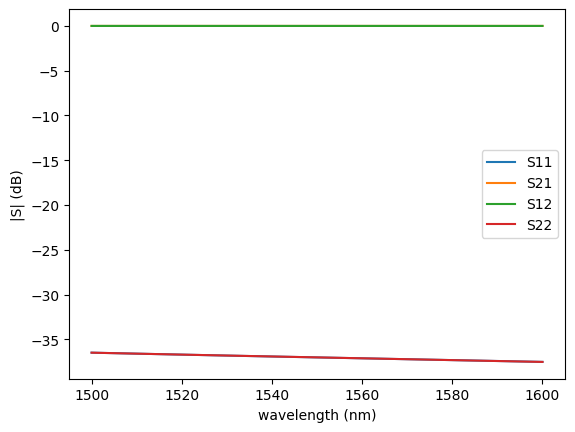

In [37]:
sp = np.load(filepaths[0])
gf.simulation.plot.plot_sparameters(sp)

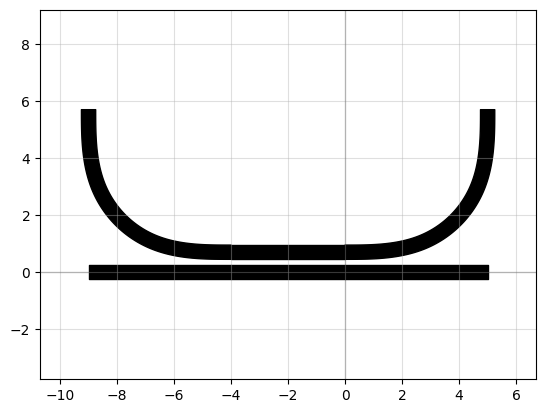

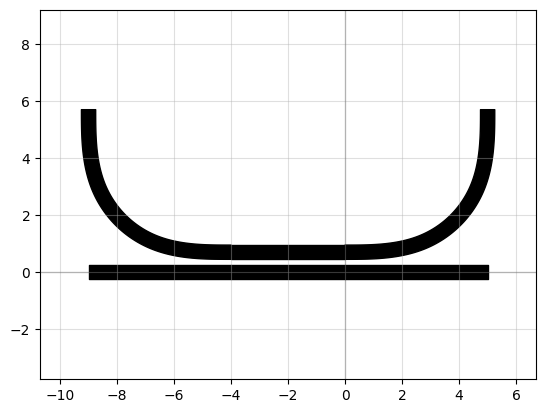

coupler_ring: uid 29e96198, ports ['o2', 'o1', 'o3', 'o4'], references ['coupler90_1', 'coupler90_2', 'coupler_straight_1'], 0 polygons

In [38]:
c = gf.components.coupler_ring()
c

<meep.simulation.Simulation object at 0x7f367c3e5460>

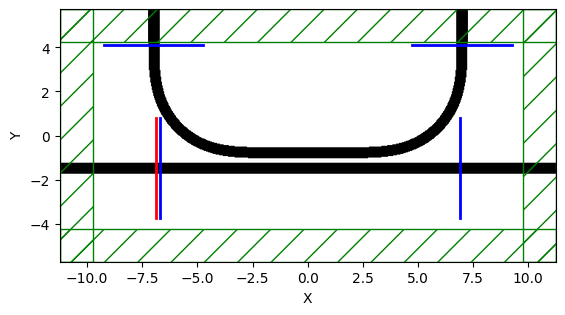

In [39]:
p = 2.5
gm.write_sparameters_meep(c, ymargin=0, ymargin_bot=p, xmargin=p, run=False)

In [40]:
c1_dict = dict(
    component=c,
    ymargin=0,
    ymargin_bot=p,
    xmargin=p,
)
jobs = [c1_dict]

filepaths = gm.write_sparameters_meep_batch(
    jobs=jobs,
    cores_per_run=4,
    total_cores=8,
    delete_temp_files=False,
    lazy_parallelism=True,
)

2023-01-03 02:13:35.097 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_batch:write_sparameters_meep_batch:138 - Simulation PosixPath('/home/runner/work/gdsfactory/gdsfactory/gdslib/sp/coupler_ring_59d93fe4.npz') not found. Adding it to the queue


2023-01-03 02:13:35.098 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_batch:write_sparameters_meep_batch:146 - Running 1 simulations


2023-01-03 02:13:35.099 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_batch:write_sparameters_meep_batch:147 - total_cores = 8 with cores_per_run = 4


2023-01-03 02:13:35.100 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_batch:write_sparameters_meep_batch:148 - Running 1 batches with up to 2 jobs each.


  0%|          | 0/1 [00:00<?, ?it/s]

2023-01-03 02:13:35.108 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_batch:write_sparameters_meep_batch:159 - Task 0 of batch 0 is job 0


2023-01-03 02:13:35.110 | INFO     | gdsfactory.simulation.gmeep.write_sparameters_meep_mpi:write_sparameters_meep_mpi:149 - Simulation PosixPath('/home/runner/work/gdsfactory/gdsfactory/gdslib/sp/coupler_ring_5465ce74.npz') already exists


{'component': coupler_ring: uid 29e96198, ports ['o2', 'o1', 'o3', 'o4'], references ['coupler90_1', 'coupler90_2', 'coupler_straight_1'], 0 polygons,
 'xmargin': 2.5,
 'ymargin': 0,
 'ymargin_bot': 2.5}


In [41]:
sp = np.load(filepaths[0])

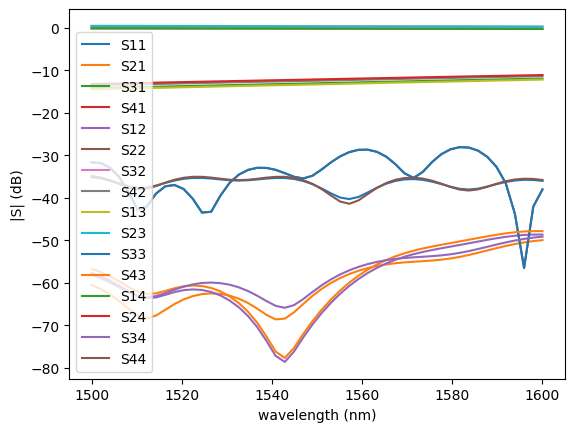

In [42]:
gm.plot.plot_sparameters(sp)

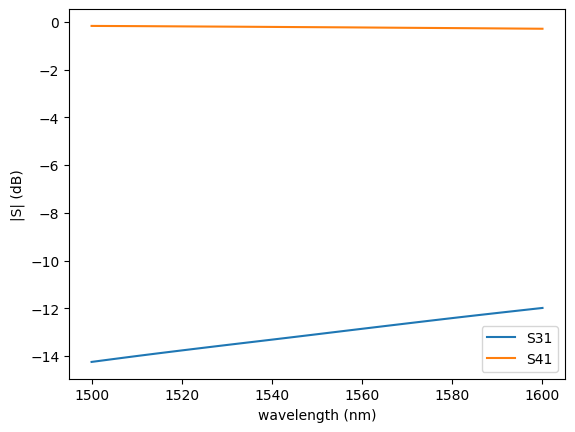

In [43]:
gm.plot.plot_sparameters(sp, keys=["o3@0,o1@0", "o4@0,o1@0"])

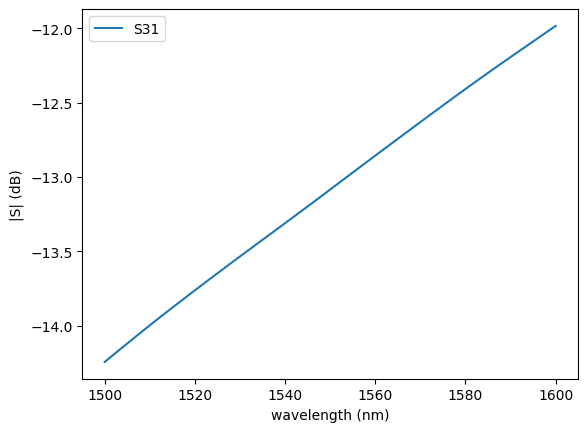

In [44]:
gm.plot.plot_sparameters(sp, keys=["s31"], with_simpler_input_keys=True)

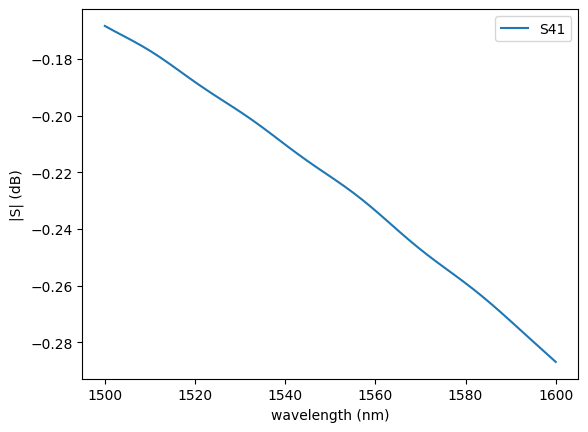

In [45]:
gm.plot.plot_sparameters(sp, keys=["s41"], with_simpler_input_keys=True)

## Visualizing the 3D Geometry

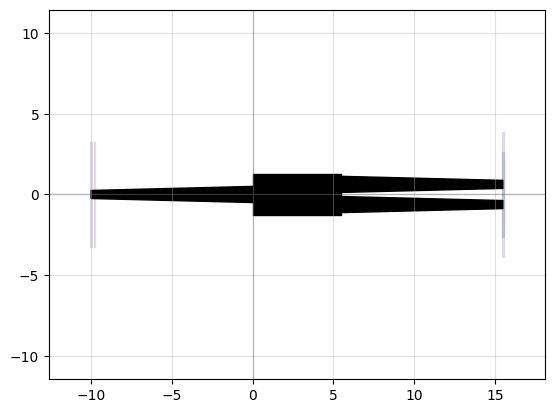

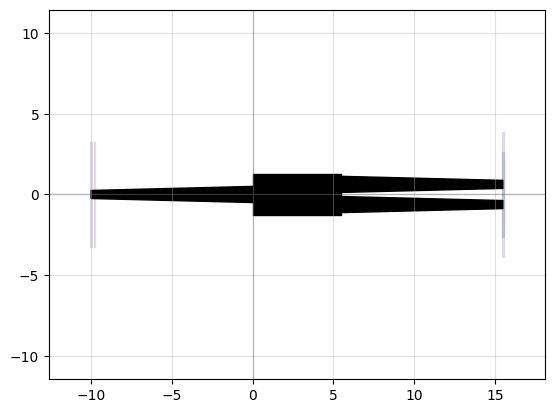

mmi1x2_add_simulation_m_ac12a352: uid 984c8157, ports ['o1', 'o2', 'o3'], references ['mmi1x2_1'], 4 polygons

In [46]:
from gdsfactory.simulation.add_simulation_markers import add_simulation_markers

c = gf.components.mmi1x2()
c = add_simulation_markers(c)
c

In [47]:
scene = c.to_3d()
scene.show()

trimesh: threejs viewer

## Adjoint Optimization

gdsfactory extends Meep's Adjoint Optimization features to optimize and generate primitive photonic components.

This example is based on this [Meep Adjoint Optimization tutorial](https://nbviewer.org/github/NanoComp/meep/blob/master/python/examples/adjoint_optimization/04-Splitter.ipynb)

In [48]:
import meep as mp
from meep import MaterialGrid, Medium, Vector3, Volume
import meep.adjoint as mpa
from meep.adjoint import (
    conic_filter,
    DesignRegion,
    get_conic_radius_from_eta_e,
    tanh_projection,
)

from autograd import tensor_jacobian_product
import autograd.numpy as npa

import gdsfactory as gf
import gdsfactory.simulation.gmeep as gm
import numpy as np

We define some useful variables that we will need later. We can leave out many of the small design parameters by defining a minimum length and applying that to a filter and using that as a constraint in our optimization.

In [49]:
design_region_width = 2.5
design_region_height = 3.5

eta_e = 0.55
minimum_length = 0.1
filter_radius = get_conic_radius_from_eta_e(minimum_length, eta_e)
eta_i = 0.5
eta_d = 1 - eta_e

resolution = 20
design_region_resolution = int(5 * resolution)

Nx = int(design_region_resolution * design_region_width)
Ny = int(design_region_resolution * design_region_height)

pml_size = 1.0
waveguide_length = 1.5
waveguide_width = 0.5
Sx = 2 * pml_size + 2 * waveguide_length + design_region_width
Sy = 2 * pml_size + design_region_height + 0.5
cell_size = (Sx, Sy)

SiO2 = Medium(index=1.44)
Si = Medium(index=3.4)

We define the design region, design variables, and the component to optimize.

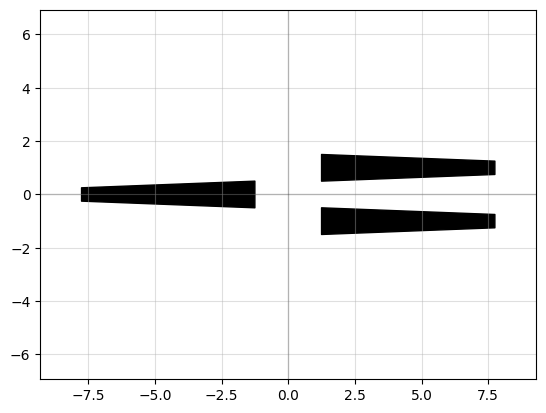

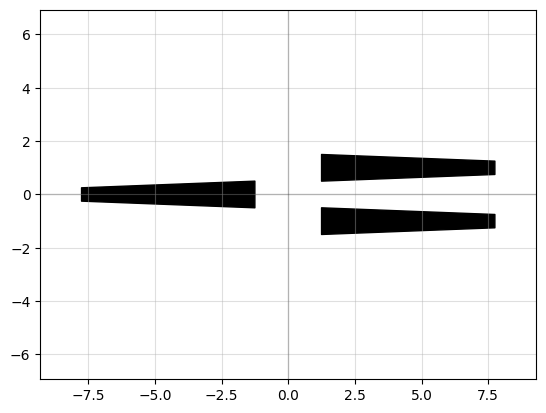

mmi1x2: uid fdae3006, ports ['o1', 'o2', 'o3'], references ['taper_1', 'taper_2', 'taper_3'], 0 polygons

In [50]:
design_variables = MaterialGrid(Vector3(Nx, Ny), SiO2, Si, grid_type="U_MEAN")
design_region = DesignRegion(
    design_variables,
    volume=Volume(
        center=Vector3(),
        size=Vector3(design_region_width, design_region_height, 0),
    ),
)

c = gf.Component("mmi1x2")

arm_separation = 1.0
straight1 = c << gf.components.taper(6.5, width2=1)
straight1.move(straight1.ports["o2"], (-design_region_width / 2.0, 0))
straight2 = c << gf.components.taper(6.5, width1=1, width2=0.5)
straight2.move(straight2.ports["o1"], (design_region_width / 2.0, 1))
straight3 = c << gf.components.taper(6.5, width1=1, width2=0.5)
straight3.move(straight3.ports["o1"], (design_region_width / 2.0, -1))

c.add_port("o1", port=straight1.ports["o1"])
c.add_port("o2", port=straight2.ports["o2"])
c.add_port("o3", port=straight3.ports["o2"])

c

We define the objective function, and obtain the optimization object.

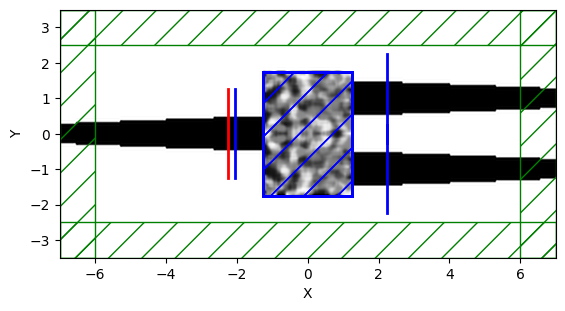

In [51]:
def mapping(x, eta, beta):

    # filter
    filtered_field = conic_filter(
        x,
        filter_radius,
        design_region_width,
        design_region_height,
        design_region_resolution,
    )

    # projection
    projected_field = tanh_projection(filtered_field, beta, eta)

    projected_field = (
        npa.fliplr(projected_field) + projected_field
    ) / 2  # up-down symmetry

    # interpolate to actual materials
    return projected_field.flatten()


seed = 240
np.random.seed(seed)
x0 = mapping(
    np.random.rand(
        Nx * Ny,
    ),
    eta_i,
    128,
)


def J(source, top, bottom):
    power = npa.abs(top / source) ** 2 + npa.abs(bottom / source) ** 2
    return npa.mean(power)


opt = gm.get_meep_adjoint_optimizer(
    c,
    J,
    [design_region],
    [design_variables],
    x0,
    resolution=resolution,
    cell_size=(
        Sx + 2 + design_region_width + 2 * pml_size,
        design_region_height + 2 * pml_size + 1.5,
    ),
    tpml=1.0,
    extend_ports_length=0,
    port_margin=1,
    port_source_offset=-5.5,
    port_monitor_offset=-5.5,
    symmetries=[mp.Mirror(direction=mp.Y)],
    wavelength_points=10,
)

We'll define a simple objective function that returns the gradient, and records the figure of merit. We'll plot the new geometry after each iteration.

In [52]:
evaluation_history = []
cur_iter = [0]


def f(v, gradient, cur_beta):
    print(f"Current iteration: {cur_iter[0] + 1}")

    f0, dJ_du = opt([mapping(v, eta_i, cur_beta)])

    plt.figure()
    ax = plt.gca()
    opt.plot2D(
        False,
        ax=ax,
        plot_sources_flag=False,
        plot_monitors_flag=False,
        plot_boundaries_flag=False,
    )
    plt.show()

    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping, 0)(
            v, eta_i, cur_beta, np.sum(dJ_du, axis=1)
        )

    evaluation_history.append(np.max(np.real(f0)))

    cur_iter[0] = cur_iter[0] + 1

    return np.real(f0)

We can define bitmasks to describe the boundary conditions.

In [53]:
# Define spatial arrays used to generate bit masks
x_g = np.linspace(-design_region_width / 2, design_region_width / 2, Nx)
y_g = np.linspace(-design_region_height / 2, design_region_height / 2, Ny)
X_g, Y_g = np.meshgrid(x_g, y_g, sparse=True, indexing="ij")

# Define the core mask
left_wg_mask = (X_g == -design_region_width / 2) & (np.abs(Y_g) <= waveguide_width)
top_right_wg_mask = (X_g == design_region_width / 2) & (
    np.abs(Y_g + arm_separation) <= waveguide_width
)
bottom_right_wg_mask = (X_g == design_region_width / 2) & (
    np.abs(Y_g - arm_separation) <= waveguide_width
)
Si_mask = left_wg_mask | top_right_wg_mask | bottom_right_wg_mask

# Define the cladding mask
border_mask = (
    (X_g == -design_region_width / 2)
    | (X_g == design_region_width / 2)
    | (Y_g == -design_region_height / 2)
    | (Y_g == design_region_height / 2)
)
SiO2_mask = border_mask.copy()
SiO2_mask[Si_mask] = False

We can then finally run the optimizer, and visualize the optimized component.

In [54]:
n = Nx * Ny  # number of parameters

# Initial guess
x = np.ones((n,)) * 0.5
x[Si_mask.flatten()] = 1  # set the edges of waveguides to silicon
x[SiO2_mask.flatten()] = 0  # set the other edges to SiO2

# lower and upper bounds
lb = np.zeros((Nx * Ny,))
lb[Si_mask.flatten()] = 1
ub = np.ones((Nx * Ny,))
ub[SiO2_mask.flatten()] = 0

cur_beta = 4
beta_scale = 2
num_betas = 7
update_factor = 12
run_optimization = False

if run_optimization:
    for iters in range(num_betas):
        print("current beta: ", cur_beta)

        if iters != num_betas - 1:
            x[:] = gm.run_meep_adjoint_optimizer(
                n,
                lambda a, g: f(a, g, cur_beta),
                x,
                lower_bound=lb,
                upper_bound=ub,
                maxeval=update_factor,
            )
        else:
            optimized_component = gm.run_meep_adjoint_optimizer(
                n,
                lambda a, g: f(a, g, cur_beta),
                x,
                lower_bound=lb,
                upper_bound=ub,
                maxeval=update_factor,
                get_optimized_component=True,
                opt=opt,
                threshold_offset_from_max=0.09,
            )
        cur_beta = cur_beta * beta_scale

    optimized_component.plot()
    final_figure_of_merit = 10 * np.log10(
        0.5 * np.array(evaluation_history[-1])
    )  # around -3.7 dB

The final optimized structure should look like this:

![optimized structure](https://user-images.githubusercontent.com/100642027/194617052-5cf0de3e-0294-441e-acad-9cd5e98ccd0b.png)

![optimization](https://user-images.githubusercontent.com/100642027/194617366-97b3e797-1fa4-40ed-8487-a5ac2b679493.png)